# Simulating Craquelure Damage in Images of Paintings

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import albumentations as A

## Experiment 1: Testing Out the Masks

In [2]:
def apply_realistic_craquelure(clean_image, crack_mask, alpha=0.6, blur=1, noise=0.02):
    """
    Blend a crack mask into a clean image with transparency, color adaptation, and optional blur/noise.

    Args:
        clean_image (PIL.Image): Clean RGB painting.
        crack_mask (PIL.Image): Grayscale crack mask (white=crack, black=bg).
        alpha (float): Crack opacity (0 = invisible, 1 = solid).
        blur (int): Gaussian blur kernel size (odd integer, 0 = no blur).
        noise (float): Amount of noise to add inside cracks (0 = none, up to ~0.1).

    Returns:
        PIL.Image: Craquelured painting.
    """
    # Convert images to NumPy
    img = np.array(clean_image).astype(np.float32) / 255.0
    mask = np.array(crack_mask.resize(clean_image.size)).astype(np.float32) / 255.0

    # Optional: blur the mask
    if blur > 0:
        mask = cv2.GaussianBlur(mask, (blur | 1, blur | 1), 0)  # ensure odd kernel size

    # Make 3-channel crack mask
    mask_3c = np.stack([mask] * 3, axis=-1)

    # Sample color from image (darkened local pixel value)
    dark_crack = img * 0.5  # 50% darker crack tone

    # Optional: add noise to cracks
    if noise > 0:
        noise_map = np.random.randn(*dark_crack.shape) * noise
        dark_crack = np.clip(dark_crack + noise_map, 0, 1)

    # Blend cracks with original image
    craquelured = img * (1 - alpha * mask_3c) + dark_crack * (alpha * mask_3c)

    return Image.fromarray((craquelured * 255).astype(np.uint8))


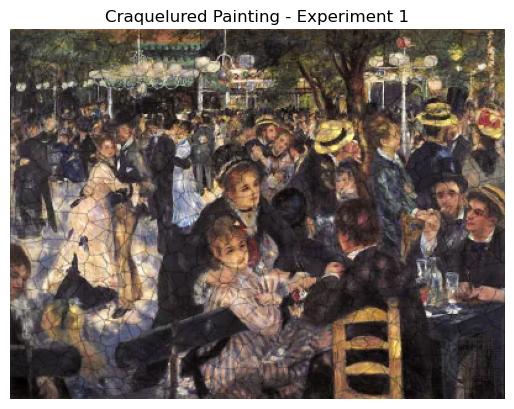

In [3]:
clean = Image.open(f"../data/sample-image-canvas-oil-Le-Moulin-de-la-Galette-1876.png").convert("RGB")
mask = Image.open(f"../data/crack-masks/0.jpg").convert("L")  # grayscale

craquelured_1 = apply_realistic_craquelure(
    clean,
    mask,
    alpha=0.8,     # make cracks more visible
    blur=1,        # retain sharpness
    noise=0.03     # add some texture variation
)

plt.imshow(craquelured_1)
plt.axis('off')
plt.title("Craquelured Painting")
plt.show()

## Experiment 2: Adding Augmentations to the Masks

In [81]:
import albumentations as A
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def augment_and_blend_craquelure(clean_image, crack_mask, alpha=0.9):
    """
    Augment a crack mask and blend it with the painting to simulate craquelure.
    Applies only flipping, brightness/contrast, and subtle color variation.
    Dilation is removed to preserve fine cracks.

    Args:
        clean_image (PIL.Image): RGB image of the painting.
        crack_mask (PIL.Image): Grayscale crack mask.
        alpha (float): Opacity of the crack overlay (0 = invisible, 1 = strong).

    Returns:
        PIL.Image: Craquelured painting.
    """

    # Convert to NumPy arrays
    img_np = np.array(clean_image).astype(np.float32) / 255.0
    mask_np = np.array(crack_mask.convert("L").resize(clean_image.size)).astype(np.uint8)

    # Stage 1: Augment the crack mask
    mask_aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0)
    ])
    augmented = mask_aug(image=mask_np)
    aug_mask = augmented["image"].astype(np.float32) / 255.0

    # Strengthen mask (no dilation)
    aug_mask = np.clip(aug_mask * 1.5, 0, 1)
    aug_mask = cv2.GaussianBlur(aug_mask, (3, 3), sigmaX=0.5)
    aug_mask_3c = np.stack([aug_mask] * 3, axis=-1)

    # Visualize the augmented mask
    plt.imshow(aug_mask, cmap='gray')
    plt.title("Augmented Crack Mask (No Dilation)")
    plt.axis('off')
    plt.show()

    # Stage 2: Blend darker crack texture
    dark_crack = np.ones_like(img_np) * [0.25, 0.22, 0.18]
    blend_aug = A.Compose([
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=1.0),
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, p=1.0)
    ])
    blend_dark_crack = blend_aug(image=(dark_crack * 255).astype(np.uint8))["image"].astype(np.float32) / 255.0

    # Final blending
    craquelured_np = img_np * (1 - alpha * aug_mask_3c) + blend_dark_crack * (alpha * aug_mask_3c)
    craquelured_img = Image.fromarray((craquelured_np * 255).astype(np.uint8))
    
    return craquelured_img


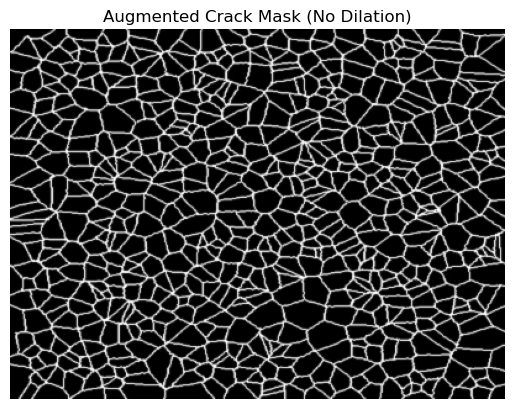

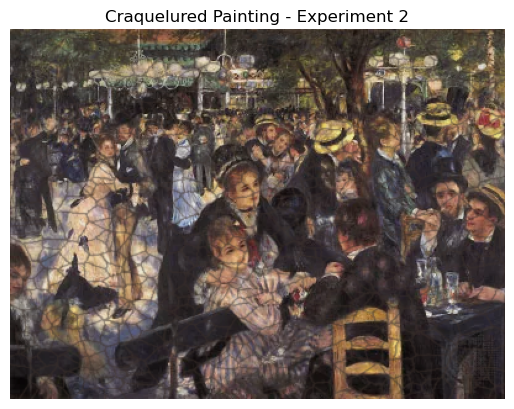

In [85]:
craquelured_2 = augment_and_blend_craquelure(clean, mask, alpha=0.6)

plt.imshow(craquelured_2)
plt.axis('off')
plt.title("Craquelured Painting - Experiment 2")
plt.show()